# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💾 The data
The team assembled the following file:

#### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group in this Multivariate Experiment is those group with "no" treatments in both feature columns: the old version with the old set of images.

As the results have been presented here already, we cannot control the experiment design anymore and cannot have data recorded that could have been used as invariant metric. This data would be compared to the previous data to ensure no other effects are going on. Such baseline values would have been very helpful before even starting the experiment. 
In this case it is also not possible to estimate required sample sizes and therefore experiment duration plannning, we assume that the experiment and data collection could have been concluded in a reasonably short time (a few weeks max).

The unit of diversion has probably been the cookie and could have been operationalized as e.g. daily unique cookies using the landing page. We assume all daily unique cookies have been recorded as rows in this DataFrame.

From the column 'converted' we can calculate the conversion rate that will serve as the Evaluation metric in this experiment for measuring success in users signing up through the landing page.

Unit of Diversion: cookies

Unit of Analysis: cookies

Evaluation metric: probability of signing up = conversion rate = conversion / cookies

In [ ]:
import pandas as pd
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


## Result analysis

### 1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.

In [ ]:
groups = df.groupby(['treatment', 'new_images'], axis=0).agg(['mean', 'sum', 'count'])

groupedby_treat = df.groupby(['treatment',], axis=0).agg(['mean', 'sum', 'count'])
groupedby_images = df.groupby(['new_images',], axis=0).agg(['mean', 'sum', 'count'])

# append groups with groupbys one a single level
groups.loc[('no','any'),:] = groupedby_treat.loc['no']
groups.loc[('yes','any'),:] = groupedby_treat.loc['yes']
groups.loc[('any','no'),:] = groupedby_images.loc['no']
groups.loc[('any','yes'),:] = groupedby_images.loc['yes']

groups = groups.sort_index()
groups

converted                 
                          mean     sum    count
treatment new_images                           
any       no          0.113576  2299.0  20242.0
          yes         0.113131  2290.0  20242.0
no        any         0.109821  2223.0  20242.0
          no          0.107104  1084.0  10121.0
          yes         0.112538  1139.0  10121.0
yes       any         0.116886  2366.0  20242.0
          no          0.120047  1215.0  10121.0
          yes         0.113724  1151.0  10121.0

In [ ]:
means = groups[('converted', 'mean')]
means

treatment  new_images
any        no            0.113576
           yes           0.113131
no         any           0.109821
           no            0.107104
           yes           0.112538
yes        any           0.116886
           no            0.120047
           yes           0.113724
Name: (converted, mean), dtype: float64

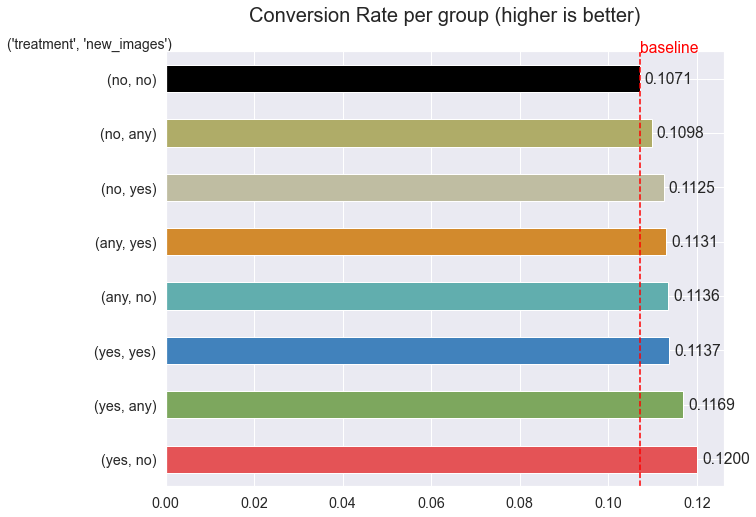

treatment  new_images
any        no            0.113576
           yes           0.113131
no         any           0.109821
           no            0.107104
           yes           0.112538
yes        any           0.116886
           no            0.120047
           yes           0.113724
Name: (converted, mean), dtype: float64

In [ ]:
conv_control = groups.iloc[3,0] # row (no, no) is the control group

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
sns.set_style('dark')
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.set(font_scale=1.3)
palette = ['#e45356', '#7da75e', '#4182bc', '#61AeAe', '#d28a2d', '#bfbda2', '#AfAc68','black']

ax = groups[('converted', 'mean')].sort_values(ascending=False).plot(kind='barh', title='Conversion Rate per group (higher is better)', 
                                     color=palette,
                                    )
for p in ax.patches:
    ax.annotate("%.4f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

ax.axvline(x=conv_control, color='red', linestyle='--')
ax.text(x=conv_control, y=7.7,s='baseline',rotation=0,va='top', color='red')
ax.set_ylabel(('treatment', 'new_images'), y=1, size=14).set_rotation(0)
plt.title('Conversion Rate per group (higher is better)', fontsize=20,pad=30)
#make_axes_area_auto_adjustable(ax)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Treatment , New Image Set')
plt.show()

groups[('converted', 'mean')]

Due to lack of a proper pre-period baseline we will compare the treatment groups with the (no, no) non-treatment (= control) group.

### 2. Can the increases observed be explained by randomness?
#### Test for Statistical Signficance

In [ ]:
import numpy as np

# Step 1: Calculate the pooled Standard Error
x_control = groups.iloc[3,1] # sum converted control group
n_control = groups.iloc[3,2] # sample size control group

def pooled_standard_error(x_control, x_treatment, n_control, n_treatment):
    import numpy as np
    p = (x_control + x_treatment) / (n_control + n_treatment)
    return np.sqrt(p*(1-p)/(n_control + n_treatment))

groups['SE'] = groups.apply( lambda row: pooled_standard_error(x_control, row[1], n_control, row[2]), axis=1)
groups.iloc[3,3] = np.nan # control group
groups

converted                         SE
                          mean     sum    count          
treatment new_images                                     
any       no          0.113576  2299.0  20242.0  0.001806
          yes         0.113131  2290.0  20242.0  0.001804
no        any         0.109821  2223.0  20242.0  0.001788
          no          0.107104  1084.0  10121.0       NaN
          yes         0.112538  1139.0  10121.0  0.002198
yes       any         0.116886  2366.0  20242.0  0.001821
          no          0.120047  1215.0  10121.0  0.002230
          yes         0.113724  1151.0  10121.0  0.002203

In [ ]:
from statsmodels.stats.power import TTestIndPower

def effect_size(mu_A, mu_B, n_A, n_B):
    #  standardized effect size, difference between the two means divided by the standard deviation. effect_size has to be positive.
    var_A = mu_A * (1-mu_A)
    var_B = mu_B * (1-mu_B)
    effect_size = (mu_B - mu_A) / ((n_A * np.sqrt(var_A) + n_B * np.sqrt(var_B)) / (n_A + n_B))
    return abs(effect_size)

def statistical_power(es, nobs1, ratio, alpha):
    # returns the power of the test with the given the observed effect size, sample sizes, alpha and ratio.
    result = TTestIndPower().solve_power(effect_size = es, 
                                        nobs1 = nobs1, 
                                        ratio = ratio,
                                        power = None,
                                        alpha = alpha,
                                        alternative='two-sided')
    return result

#nobs1 = n_A
#ratio = n_B / n_A
alpha = 0.05

groups['stat_power'] = groups.apply(lambda row: statistical_power(effect_size(x_control/n_control, #mu control
                                                                      row[0], #mu treatment
                                                                      n_control, 
                                                                      row[2]), # n treatment
                                                           n_control, #nobs1
                                                           row[2]/n_control, # ratio
                                                           alpha), 
                            axis=1)
groups.iloc[3,4] = np.nan # control group
groups

converted                         SE stat_power
                          mean     sum    count                     
treatment new_images                                                
any       no          0.113576  2299.0  20242.0  0.001806   0.393588
          yes         0.113131  2290.0  20242.0  0.001804   0.350473
no        any         0.109821  2223.0  20242.0  0.001788   0.110555
          no          0.107104  1084.0  10121.0       NaN        NaN
          yes         0.112538  1139.0  10121.0  0.002198   0.235377
yes       any         0.116886  2366.0  20242.0  0.001821   0.716493
          no          0.120047  1215.0  10121.0  0.002230   0.827234
          yes         0.113724  1151.0  10121.0  0.002203   0.324022

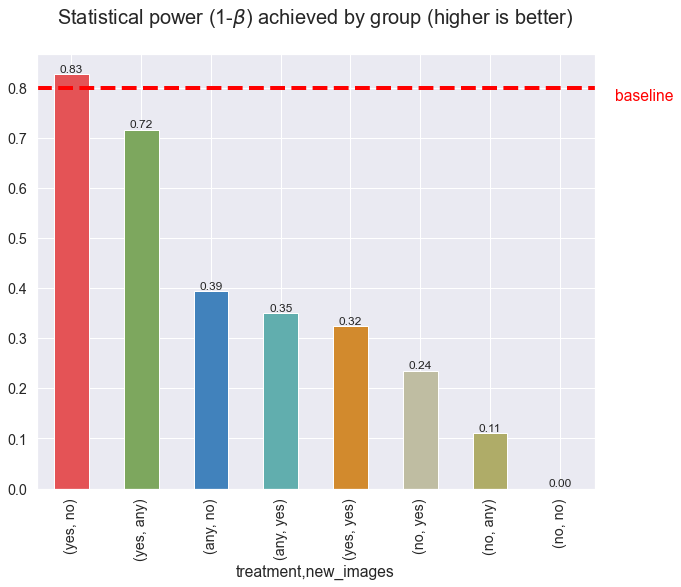

In [ ]:
sns.set_style('dark')
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.set(font_scale=1.3)

# plot
#dhat = groups[['d_hat', 'margin_of_error']].sort_values(by='d_hat',ascending=False)
power = groups.stat_power.sort_values(ascending=False).plot(kind='bar', color=palette)
power.axhline(y=0.8, color='red', linestyle='--', linewidth=4)
power.text(x=7.8, y=0.8,s='baseline',rotation=0,va='top', color='red')
# iterate bars
for bar in power.patches:
    power.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 5),
                   textcoords='offset points', horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Treatment , New Image Set')
#plt.errorbar(range(0,8), dhat.d_hat, yerr=dhat.margin_of_error, fmt="o", color="purple", capsize=7, marker='s')
plt.title("Statistical power (1-$ \\beta$) achieved by group (higher is better)", fontsize=20,pad=30)
plt.show()

The Statistical Power observed is quite low for most of tests. By default a statistical power of 0.8 is used, which equates to beta = 0.2 as the Type II error that you are ready to accept. In this experiment most tests lack observations with the given the observed effect size, alpha and ratio. Just a single test has achieved a high statistical power to be actually usuable: group (yes, no) with a statistical power of 0.827234 which can be considered as sufficient. In absence of a minimum effect size that should have been decided on in the experiment design phase, we assume that all groups that reach sufficient statistical power are also worth the effort to be implemented. 

It remains unclear if this MVT Experiment was aborted on purpose or happened to have actually too few observations by accident. Especially for the second feature, e.g. (no, yes) we are far off from solid numbers to base decisions on.
Maybe this aborted experiment was just a opportunity cost for a much better test that became ready to run, and all is left on this experiment, is to salvage from what is left over if any.

Never mind, we will ignore this power issue for now and address this in the conclusion again.

#### Null Hypothesis

we look at the difference in conversion rate as $ \hat{d} $ between observed groups and formulate our Null Hypothesis as follows:
$$ \hat{d} = \text{conversion rate treatment} - \text{conversion rate control} $$

$$ H_0: d = 0 \qquad(\hat{p}_{cont} = \hat{p}_{exp})\qquad  \hat{d} \sim N(0, SE_{pool})  $$

In [ ]:
conv_control = groups.iloc[3,0] # row (no, no) is the control group
print(f'control group conversion rate: {conv_control}')

# d_hat = conv_treatment - conv_control
groups['d_hat'] = groups.apply( lambda row: row[0]-conv_control, axis=1)
groups.iloc[3,5] = np.nan # control group
groups

control group conversion rate: 0.10710404110265784


converted                         SE stat_power     d_hat
                          mean     sum    count                               
treatment new_images                                                          
any       no          0.113576  2299.0  20242.0  0.001806   0.393588  0.006472
          yes         0.113131  2290.0  20242.0  0.001804   0.350473  0.006027
no        any         0.109821  2223.0  20242.0  0.001788   0.110555  0.002717
          no          0.107104  1084.0  10121.0       NaN        NaN       NaN
          yes         0.112538  1139.0  10121.0  0.002198   0.235377  0.005434
yes       any         0.116886  2366.0  20242.0  0.001821   0.716493  0.009782
          no          0.120047  1215.0  10121.0  0.002230   0.827234  0.012943
          yes         0.113724  1151.0  10121.0  0.002203   0.324022  0.006620

In [ ]:
# margins of error

import scipy.stats as st

alpha = 0.05
#z-score
z = st.norm.ppf(1-alpha/2) # two tails
print(z) # check

groups['margin_of_error'] = groups.apply( lambda row: row.SE * z, axis=1)
groups.iloc[3,6] = np.nan # control group
groups

1.959963984540054


converted                         SE stat_power  \
                          mean     sum    count                        
treatment new_images                                                   
any       no          0.113576  2299.0  20242.0  0.001806   0.393588   
          yes         0.113131  2290.0  20242.0  0.001804   0.350473   
no        any         0.109821  2223.0  20242.0  0.001788   0.110555   
          no          0.107104  1084.0  10121.0       NaN        NaN   
          yes         0.112538  1139.0  10121.0  0.002198   0.235377   
yes       any         0.116886  2366.0  20242.0  0.001821   0.716493   
          no          0.120047  1215.0  10121.0  0.002230   0.827234   
          yes         0.113724  1151.0  10121.0  0.002203   0.324022   

                         d_hat margin_of_error  
                                                
treatment new_images                            
any       no          0.006472        0.003539  
          yes         0.006027        0.003535  
no        any         0.002717        0.003504  
          no               NaN             NaN  
          yes         0.005434        0.004307  
yes       any         0.009782        0.003570  
          no          0.012943        0.004371  
          yes         0.006620        0.004317

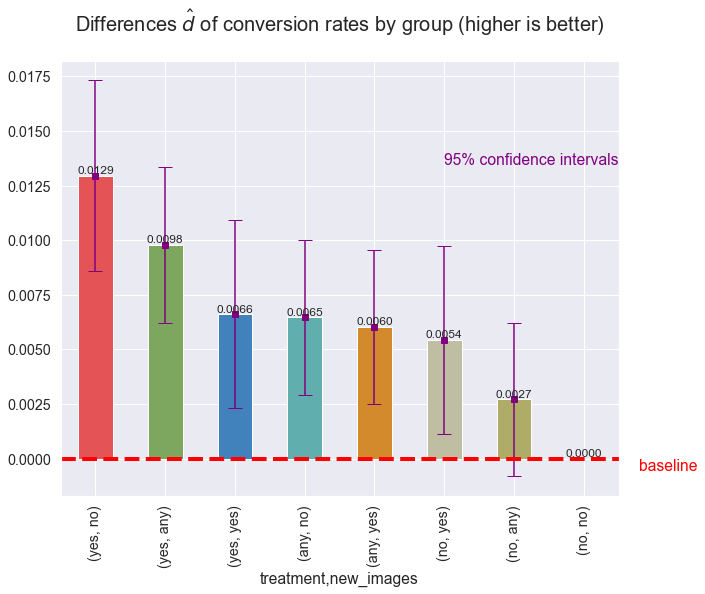

In [ ]:
sns.set_style('dark')
fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.set(font_scale=1.3)

# plot
dhat = groups[['d_hat', 'margin_of_error']].sort_values(by='d_hat',ascending=False)
delta = dhat.d_hat.plot(kind='bar', color=palette)
delta.axhline(y=0, color='red', linestyle='--', linewidth=4)
delta.text(x=7.8, y=0,s='baseline',rotation=0,va='top', color='red')
delta.text(x=5, y=0.014,s='95% confidence intervals',rotation=0,va='top', color='purple')
# iterate bars
for bar in delta.patches:
    delta.annotate(format(bar.get_height(), '.4f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 5),
                   textcoords='offset points', horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Treatment , New Image Set')
plt.errorbar(range(0,8), dhat.d_hat, yerr=dhat.margin_of_error, fmt="o", color="purple", capsize=7, marker='s')
plt.title('Differences $\hat{d}$ of conversion rates by group (higher is better)', fontsize=20,pad=30)
plt.show()

In [ ]:
dhat.d_hat

treatment  new_images
yes        no            0.012943
           any           0.009782
           yes           0.006620
any        no            0.006472
           yes           0.006027
no         yes           0.005434
           any           0.002717
           no                 NaN
Name: d_hat, dtype: float64

In [ ]:
groups[['d_hat', 'margin_of_error']].sort_values(by='d_hat',ascending=False, axis=0)


d_hat margin_of_error
                                              
treatment new_images                          
yes       no          0.012943        0.004371
          any         0.009782        0.003570
          yes         0.006620        0.004317
any       no          0.006472        0.003539
          yes         0.006027        0.003535
no        yes         0.005434        0.004307
          any         0.002717        0.003504
          no               NaN             NaN

In [ ]:
# determine confidence interval bounds
groups['ci_lower_bound'] = groups.apply( lambda row: row.d_hat - row.margin_of_error , axis=1)
groups['ci_upper_bound'] = groups.apply( lambda row: row.d_hat + row.margin_of_error, axis=1)
groups

converted                         SE stat_power  \
                          mean     sum    count                        
treatment new_images                                                   
any       no          0.113576  2299.0  20242.0  0.001806   0.393588   
          yes         0.113131  2290.0  20242.0  0.001804   0.350473   
no        any         0.109821  2223.0  20242.0  0.001788   0.110555   
          no          0.107104  1084.0  10121.0       NaN        NaN   
          yes         0.112538  1139.0  10121.0  0.002198   0.235377   
yes       any         0.116886  2366.0  20242.0  0.001821   0.716493   
          no          0.120047  1215.0  10121.0  0.002230   0.827234   
          yes         0.113724  1151.0  10121.0  0.002203   0.324022   

                         d_hat margin_of_error ci_lower_bound ci_upper_bound  
                                                                              
treatment new_images                                                          
any       no          0.006472        0.003539       0.002933       0.010011  
          yes         0.006027        0.003535       0.002492       0.009562  
no        any         0.002717        0.003504      -0.000787       0.006221  
          no               NaN             NaN            NaN            NaN  
          yes         0.005434        0.004307       0.001127       0.009742  
yes       any         0.009782        0.003570       0.006212       0.013351  
          no          0.012943        0.004371       0.008572       0.017314  
          yes         0.006620        0.004317       0.002302       0.010937

In [ ]:
def check_significance(ci_lower_bound,ci_upper_bound):
    if(0 >= ci_lower_bound and 0 <= ci_upper_bound):
        #print('Null hypothesis cannot be rejected as zero is inside the confidence interval')
        return False
    else:
        #print('Null hypothesis can be rejected as zero is outside the confidence interval')
        #print('as per experiment design there is a significant reason to doubt the Null hypothesis and') 
        #print('conclude that there is indeed a change in the data between control and treatment groups')
        return True    

In [ ]:
# check groups for significance

not_significant = (groups['ci_lower_bound'] < 0) & (groups['ci_upper_bound'] > 0) 
significant = ~not_significant
groups['significant'] = significant
groups['H0_rejected'] = significant
groups.iloc[3,9] = False # control group
groups.iloc[3,10] = False # control group
groups

converted                         SE stat_power  \
                          mean     sum    count                        
treatment new_images                                                   
any       no          0.113576  2299.0  20242.0  0.001806   0.393588   
          yes         0.113131  2290.0  20242.0  0.001804   0.350473   
no        any         0.109821  2223.0  20242.0  0.001788   0.110555   
          no          0.107104  1084.0  10121.0       NaN        NaN   
          yes         0.112538  1139.0  10121.0  0.002198   0.235377   
yes       any         0.116886  2366.0  20242.0  0.001821   0.716493   
          no          0.120047  1215.0  10121.0  0.002230   0.827234   
          yes         0.113724  1151.0  10121.0  0.002203   0.324022   

                         d_hat margin_of_error ci_lower_bound ci_upper_bound  \
                                                                               
treatment new_images                                                           
any       no          0.006472        0.003539       0.002933       0.010011   
          yes         0.006027        0.003535       0.002492       0.009562   
no        any         0.002717        0.003504      -0.000787       0.006221   
          no               NaN             NaN            NaN            NaN   
          yes         0.005434        0.004307       0.001127       0.009742   
yes       any         0.009782        0.003570       0.006212       0.013351   
          no          0.012943        0.004371       0.008572       0.017314   
          yes         0.006620        0.004317       0.002302       0.010937   

                     significant H0_rejected  
                                              
treatment new_images                          
any       no                True        True  
          yes               True        True  
no        any              False       False  
          no               False       False  
          yes               True        True  
yes       any               True        True  
          no                True        True  
          yes               True        True

### 3. Conclusion
The only group not signifcantly different from our baseline group at a confidence level of 95% (alpha = 0.05) is the group with the old landing page (no treatment) and all those visitors seen both old and new images (undetermined).
Here we cannot state that at least with 95% chance that the population mean conversion rate is different from zero, as the confidence interval calculated (-0.000787, 0.006221) contains the baseline zero, hence reducing probability further down to unacceptable levels. We could calculate this chance however won't change anything really.
The Null Hypothesis cannot be rejected.

All other groups converted significantly better than the baseline, as here the chance of a mean conversion rate higher than the baseline can be concluded significantly and each Null Hypothesis can be rejected and the Alternative Hypothesis confirmed. These conversion rate changes cannot be explained by randomness, unless you apply unusual strict confidence requirements; just to answer the posed headline question directly.

Beyond the mere statistical significance is now the question what to make of this Multivariate Experiment outcome.
Two features have been subject to testing and each combination has been tested.

While each feature alone improved the conversion well with (yes, no) and (no, yes), the certainly stronger change is the treatment group (yes, no) with its new landing page with 0.012943 vs. 0.005434 (no, yes) improvement over control.

If we look then at the group which applied both changes at the same time, we have to ascertain that both changes at the same time (yes, yes) are not the most effective combination apparently, as its conversion is considerably lower $\hat{d}$ 0.006620 vs. 0.012943 (yes, no). This can be explained by an interaction effect between both features, which can only be seen and conlcuded from a Multivariate (MVT) test such as this. Such interaction effects are rather rare and regularly single variate A/B tests are adequate and its experiments are less time and traffic consuming. However in this case the MVT was beneficical in detecting this interaction going on. 

Earlier we calculated the statistical power for all group combinations and had to learn that there were not enough observations for all groups except one, in order to achieve high statistical power for the given effect sizes, sample sizes, ratio of sample sizes, differences in conversion and alpha. This single group is once again (yes, no) with statistical power greater than 80%.

Therefore the conclusion and recommendation is to implement the 'Treatment' group (yes, no) alone with the old image set. Images are recommended to be subject for consecutive further testing, as this tested set of new images had also significant positive effect on conversion. But as it just watered down the landing page conversion we recommend to waive this implementation at this time. 

Whichever test is going to follow next, please take into account upfront the minimum required sample size per variant and overall duration the test will have to run for the sake of statistical power. Thank you.
